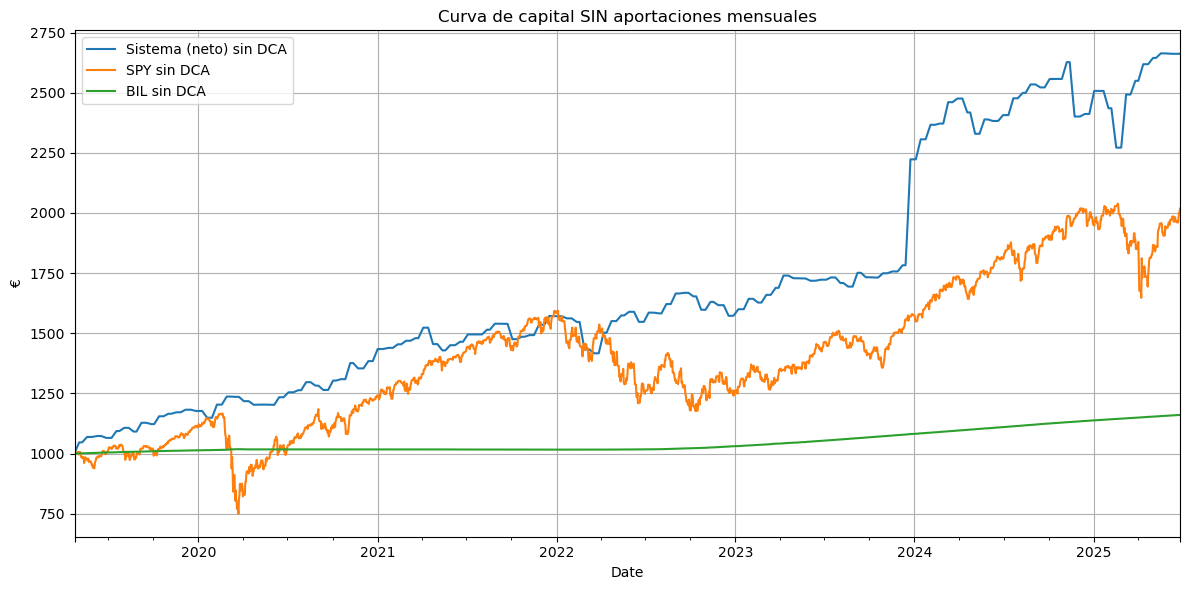

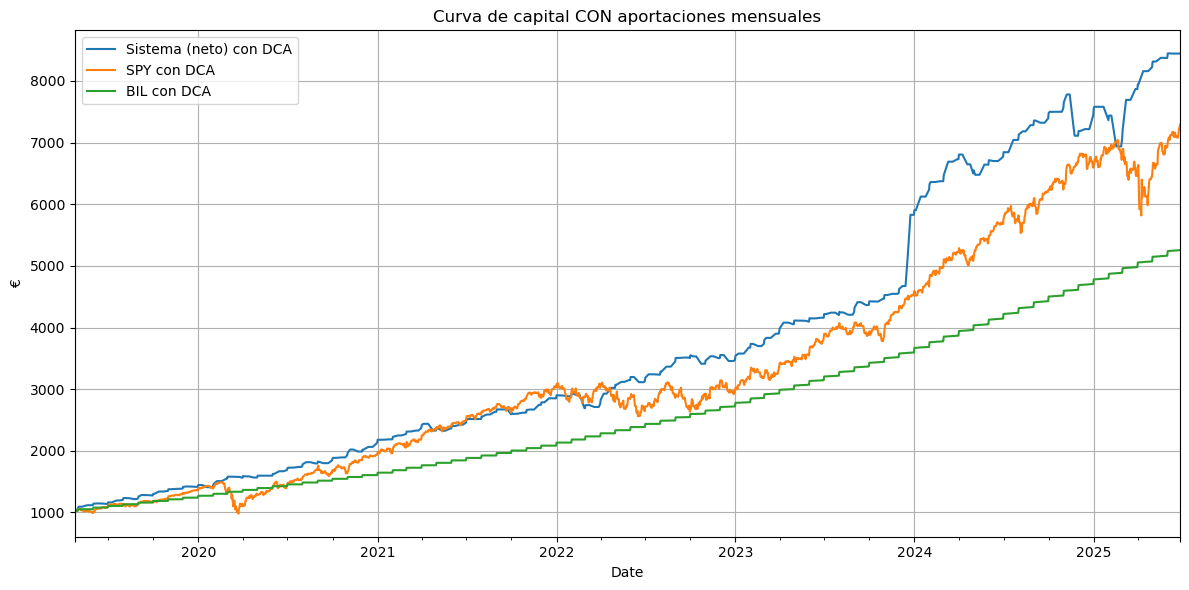

,Rentabilidad acumulada (%),Volatilidad (%),Sharpe Ratio,Max Drawdown (%),Asimetría,Curtosis
Sistema,166.155413,3.731304,2.949703,35.532072,3.315349,34.203683
S&P 500,101.834135,17.162369,0.543441,41.778423,-0.633527,20.613971
BIL (cash),16.043316,0.223796,7.427994,0.212531,1.431849,3.020071


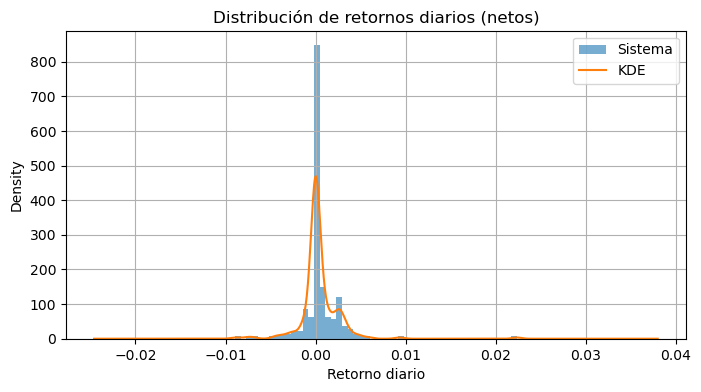

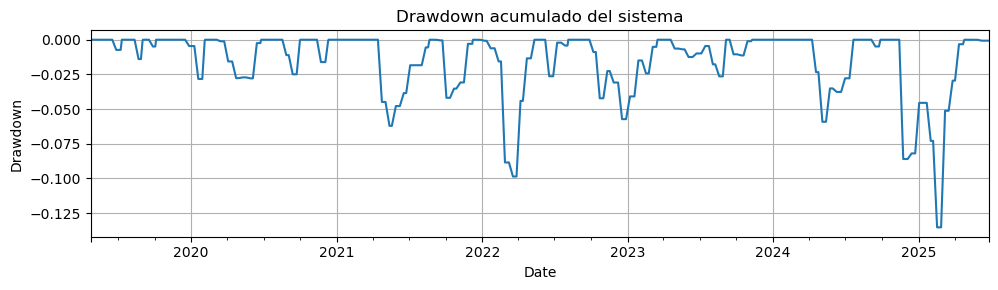

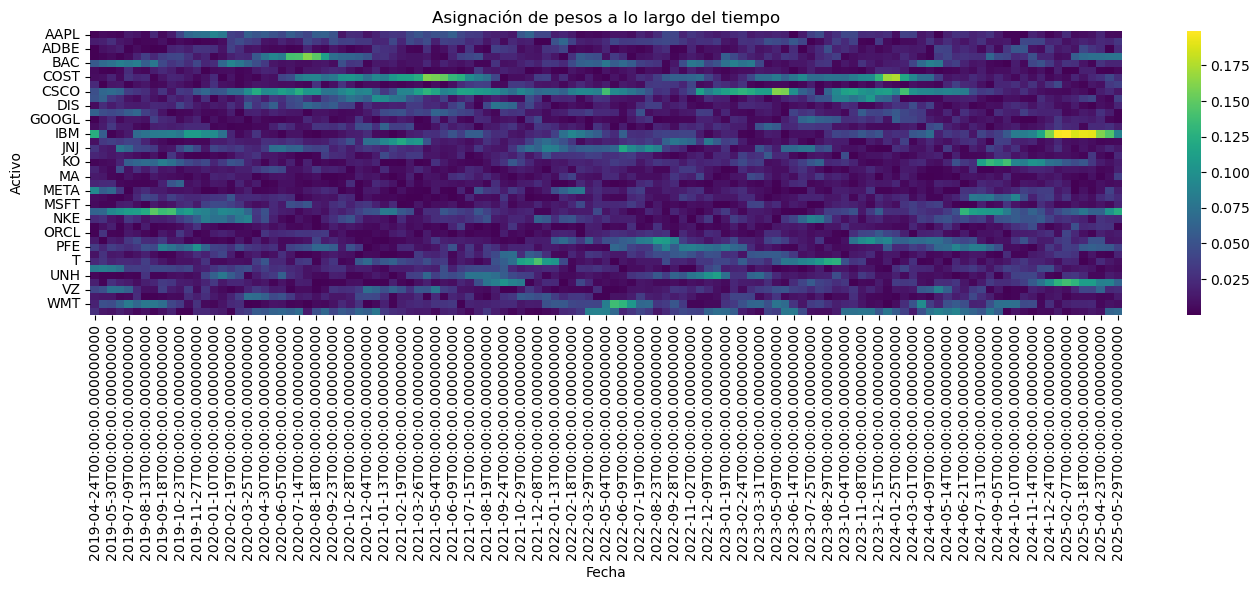

In [1]:
# 1. CONFIGURACIÓN INICIAL ---------------------------------------------------
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import yfinance as yf
import warnings
from pathlib import Path
from scipy.stats import kurtosis, skew

warnings.simplefilter("ignore", FutureWarning)

PROJECT_ROOT = Path().resolve().parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src import config as cfg

# 2. CARGA DE RESULTADOS  ----------------------------------------------------
res_df = joblib.load(cfg.RESULT / f"backtest_{cfg.MODEL_TYPE}.pkl")
df_prices = pd.read_parquet(cfg.DATA / "raw" / "prices.parquet")

tickers = df_prices.columns[:res_df["w_star"].iloc[0].shape[0]]

# 2.1 RECONSTRUIR RETORNOS DIARIOS ------------------------------------------
# Creamos una serie diaria con índice igual al de precios y valores 0
ret_sys = pd.Series(0.0, index=df_prices.index)

# Ordenamos el DataFrame por fecha por si acaso
res_df = res_df.sort_values("fecha")

res_df = res_df.sort_index()

for start, row in res_df.iterrows():      # ← start es la fecha de rebalanceo
    end  = start + pd.Timedelta(days=cfg.REBAL_FREQ - 1)
    days = ret_sys.loc[start:end].index
    if len(days) == 0:
        continue

    r_total = row["ret_neto"]             # retorno acumulado del bloque
    r_daily = (1 + r_total)**(1/len(days)) - 1   # retorno diario uniforme
    ret_sys.loc[days] = r_daily

# Eliminamos los días previos al primer retorno no nulo
ret_sys = ret_sys.loc[ret_sys.ne(0).idxmax():]

# 3. BENCHMARKS --------------------------------------------------------------
tickers_bench = ["SPY", "BIL"]
raw = yf.download(tickers_bench,
                  start=ret_sys.index.min(), progress=False, auto_adjust=False)
prices_bench = (raw["Adj Close"]
                if "Adj Close" in raw.columns.get_level_values(0)
                else raw["Close"]).ffill()

ret_bench = np.log(prices_bench / prices_bench.shift(1)).dropna()
ret_bench = ret_bench.reindex(ret_sys.index).fillna(0)

# 4. APORTACIONES MENSUALES --------------------------------------------------
capital_ini = 1000
aport_mes = {2019:25, 2020:30, 2021:40, 2022:50, 2023:60, 2024:75, 2025:75}

aport = pd.Series(0.0, index=ret_sys.index)
primer_dia_mes = ret_sys.index.to_series().groupby(ret_sys.index.to_period('M')).first()
for fecha in primer_dia_mes:
    if fecha.year in aport_mes:
        aport.at[fecha] = aport_mes[fecha.year]

def curva_con_aportes(ret_series, capital_ini, aport_series):
    wealth = pd.Series(index=ret_series.index, dtype=float)
    wealth.iloc[0] = capital_ini + aport_series.iloc[0]
    for t in range(1, len(ret_series)):
        wealth.iloc[t] = (wealth.iloc[t-1] + aport_series.iloc[t]) * (1 + ret_series.iloc[t])
    return wealth

# 5. CURVAS DE CAPITAL -------------------------------------------------------
wealth_sys_ini  = (1 + ret_sys).cumprod() * capital_ini
wealth_spy_ini  = (1 + ret_bench['SPY']).cumprod()
wealth_spy_ini  = wealth_spy_ini / wealth_spy_ini.iloc[0] * capital_ini
wealth_cash_ini = (1 + ret_bench['BIL']).cumprod()
wealth_cash_ini = wealth_cash_ini / wealth_cash_ini.iloc[0] * capital_ini

wealth_sys_dca  = curva_con_aportes(ret_sys, capital_ini, aport)
wealth_spy_dca  = curva_con_aportes(ret_bench['SPY'], capital_ini, aport)
wealth_cash_dca = curva_con_aportes(ret_bench['BIL'], capital_ini, aport)

# --- Gráfico sin DCA
plt.figure(figsize=(12,6))
wealth_sys_ini.plot(label='Sistema (neto) sin DCA')
wealth_spy_ini.plot(label='SPY sin DCA')
wealth_cash_ini.plot(label='BIL sin DCA')
plt.title('Curva de capital SIN aportaciones mensuales')
plt.ylabel('€'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# --- Gráfico con DCA
plt.figure(figsize=(12,6))
wealth_sys_dca.plot(label='Sistema (neto) con DCA')
wealth_spy_dca.plot(label='SPY con DCA')
wealth_cash_dca.plot(label='BIL con DCA')
plt.title('Curva de capital CON aportaciones mensuales')
plt.ylabel('€'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# 6. MÉTRICAS ----------------------------------------------------------------
def resumen_metricas(ret):
    return {
        "Rentabilidad acumulada (%)": 100*((1+ret).prod() - 1),
        "Volatilidad (%)": 100*np.std(ret)*np.sqrt(252),
        "Sharpe Ratio": np.mean(ret)/np.std(ret)*np.sqrt(252),
        "Max Drawdown (%)": 100*((1+ret).cumprod().cummax()-(1+ret).cumprod()).max(),
        "Asimetría": skew(ret),
        "Curtosis": kurtosis(ret)
    }

metrics = pd.DataFrame({
    "Sistema": resumen_metricas(ret_sys),
    "S&P 500": resumen_metricas(ret_bench['SPY']),
    "BIL (cash)": resumen_metricas(ret_bench['BIL'])
}).T

display(metrics)

# 7. HISTOGRAMA DE RETORNOS --------------------------------------------------
plt.figure(figsize=(8,4))
ret_sys.hist(bins=50, density=True, alpha=0.6, label="Sistema")
ret_sys.plot(kind="kde", label="KDE")
plt.title("Distribución de retornos diarios (netos)")
plt.xlabel("Retorno diario"); plt.grid(True); plt.legend(); plt.show()

# 8. DRAWDOWN ----------------------------------------------------------------
cum_returns = (1 + ret_sys).cumprod()
drawdown = cum_returns / cum_returns.cummax() - 1

plt.figure(figsize=(10,3))
drawdown.plot()
plt.title("Drawdown acumulado del sistema")
plt.ylabel("Drawdown"); plt.grid(); plt.tight_layout(); plt.show()

# 9. HEATMAP DE PESOS --------------------------------------------------------
df_w = pd.DataFrame(
    list(res_df.dropna(subset=["w_star"])["w_star"]),
    index=res_df.dropna(subset=["w_star"]).index,
    columns=tickers
)

plt.figure(figsize=(14,6))
sns.heatmap(df_w.T, cmap="viridis", cbar=True)
plt.title("Asignación de pesos a lo largo del tiempo")
plt.xlabel("Fecha"); plt.ylabel("Activo"); plt.tight_layout(); plt.show()


In [15]:
import pandas as pd, numpy as np, joblib, yfinance as yf, matplotlib.pyplot as plt
import seaborn as sns
import pathlib, sys, warnings
from scipy.stats import kurtosis, skew

warnings.simplefilter("ignore", FutureWarning)

ROOT = pathlib.Path().resolve().parent.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import config as cfg



In [17]:
START = "2019-01-02"
END = pd.Timestamp.today().normalize()

gspc = yf.download("^GSPC", start=START, end=END, progress=False)
price_gs = gspc["Adj Close"] if "Adj Close" in gspc.columns else gspc["Close"]
calendar = price_gs.dropna().index



In [19]:
bt_path = cfg.RESULT / "backtest_cnn5d.pkl"
res_df = joblib.load(bt_path)

ret_sys = res_df["retorno"].reindex(calendar).fillna(0.0)
print("✅ Retornos del sistema cargados:", ret_sys.shape)



✅ Retornos del sistema cargados: (1632,)


In [21]:
tickers = ["SPY", "BIL"]
raw_bench = yf.download(tickers, start=START, end=END, progress=False)

if isinstance(raw_bench.columns, pd.MultiIndex):
    prices_b = raw_bench["Adj Close"] if "Adj Close" in raw_bench.columns.levels[0] else raw_bench["Close"]
else:
    prices_b = raw_bench

prices_b = prices_b.ffill()
ret_bench = np.log(prices_b / prices_b.shift(1)).reindex(calendar).dropna()

ret_spy = ret_bench["SPY"]
ret_cash = ret_bench["BIL"]
print("✅ Benchmarks cargados:", ret_bench.shape)


✅ Benchmarks cargados: (1631, 2)


In [23]:
def stats(r):
    ann = np.sqrt(252)
    w = (1 + r).cumprod()
    return {
        "Rentabilidad (%)" : (w.iloc[-1] - 1) * 100,
        "Volatilidad (%)" : r.std(ddof=1) * ann * 100,
        "Sharpe" : r.mean() / r.std(ddof=1) * ann,
        "MaxDD (%)" : (w.cummax() - w).max() * 100,
        "Asimetría" : skew(r),
        "Curtosis" : kurtosis(r)
    }


In [25]:
tabla = pd.DataFrame({
    "CNN5D": stats(ret_sys),
    "SPY"  : stats(ret_spy),
    "BIL"  : stats(ret_cash)
}).T.round(2)

print("\n── Métricas 2019-hoy (CNN5D + NSGA-II) ──")
display(tabla)



── Métricas 2019-hoy (CNN5D + NSGA-II) ──


,Rentabilidad (%),Volatilidad (%),Sharpe,MaxDD (%),Asimetría,Curtosis
CNN5D,143.24,11.16,1.29,37.05,1.07,57.05
SPY,138.52,20.37,0.76,48.90,-0.57,13.57
BIL,16.93,0.25,9.54,0.21,0.85,1.27


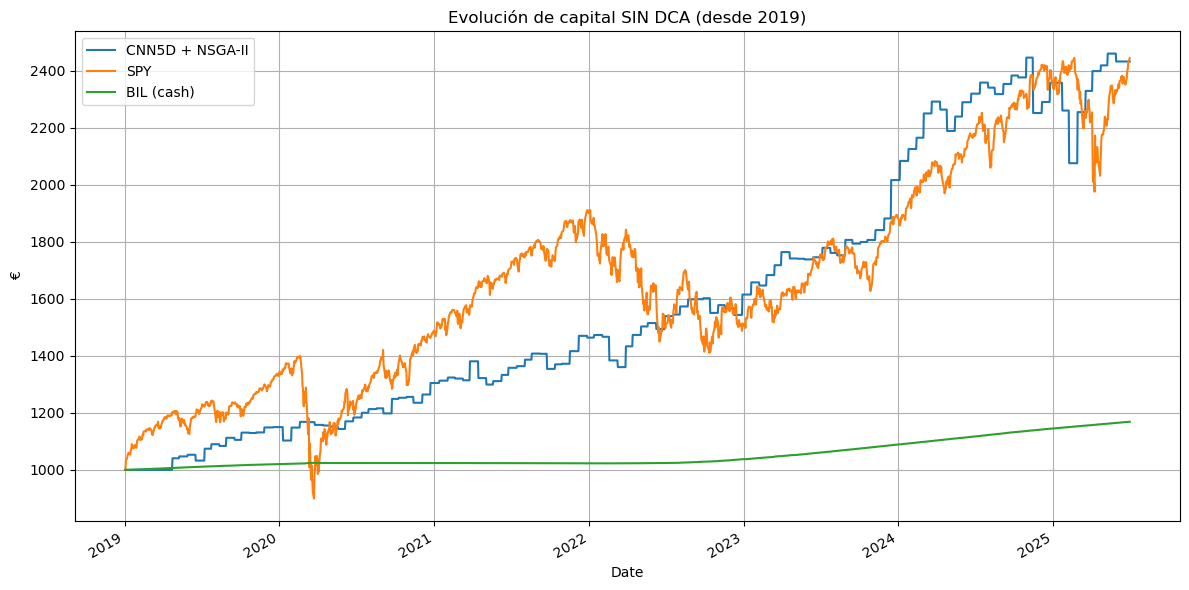

In [27]:
capital_ini = 1000
wealth_cnn_ini = (1 + ret_sys).cumprod() * capital_ini
wealth_spy_ini = (1 + ret_spy).cumprod() / (1 + ret_spy).cumprod().iloc[0] * capital_ini
wealth_cash_ini = (1 + ret_cash).cumprod() / (1 + ret_cash).cumprod().iloc[0] * capital_ini

plt.figure(figsize=(12,6))
wealth_cnn_ini.plot(label='CNN5D + NSGA-II')
wealth_spy_ini.plot(label='SPY')
wealth_cash_ini.plot(label='BIL (cash)')
plt.title('Evolución de capital SIN DCA (desde 2019)')
plt.ylabel('€')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


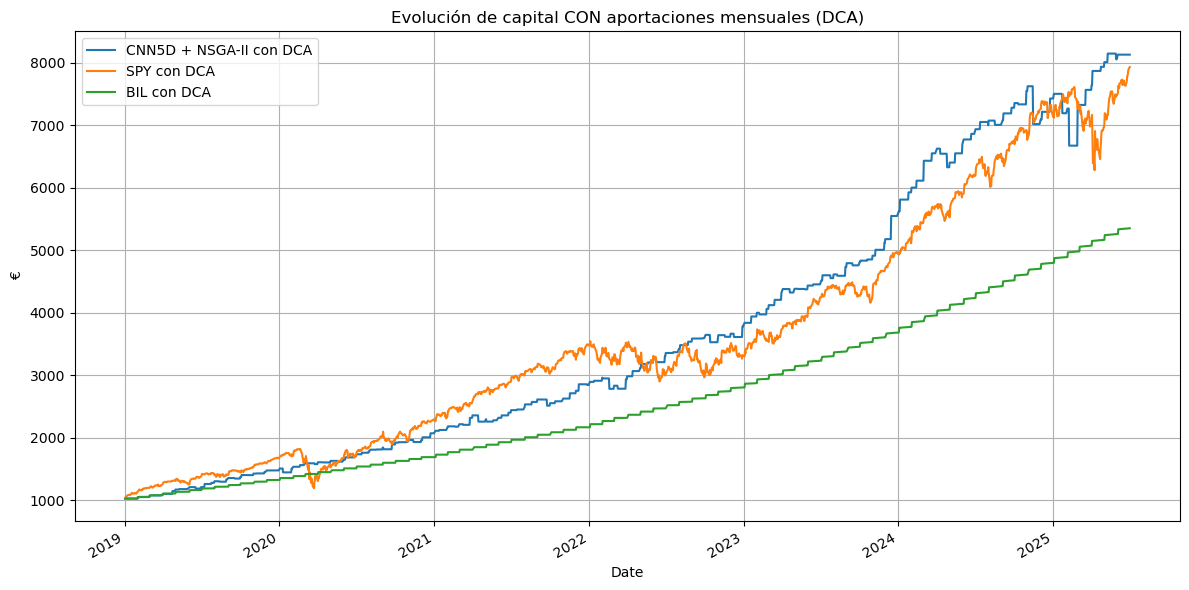

In [29]:
aport_mes = {2019:25, 2020:30, 2021:40, 2022:50, 2023:60, 2024:75, 2025:75}
aport = pd.Series(0, index=ret_sys.index)
primer_dia_mes = ret_sys.index.to_series().groupby(ret_sys.index.to_period('M')).first()

for fecha in primer_dia_mes:
    if fecha.year in aport_mes:
        aport.at[fecha] = aport_mes[fecha.year]

def curva_con_aportes(ret_series, capital_ini, aport_series):
    wealth = pd.Series(index=ret_series.index, dtype=float)
    wealth.iloc[0] = capital_ini + aport_series.iloc[0]
    for t in range(1, len(ret_series)):
        wealth.iloc[t] = (wealth.iloc[t-1] + aport_series.iloc[t]) * (1 + ret_series.iloc[t])
    return wealth

wealth_cnn_dca = curva_con_aportes(ret_sys, capital_ini, aport)
wealth_spy_dca = curva_con_aportes(ret_spy, capital_ini, aport)
wealth_cash_dca = curva_con_aportes(ret_cash, capital_ini, aport)

plt.figure(figsize=(12,6))
wealth_cnn_dca.plot(label='CNN5D + NSGA-II con DCA')
wealth_spy_dca.plot(label='SPY con DCA')
wealth_cash_dca.plot(label='BIL con DCA')
plt.title('Evolución de capital CON aportaciones mensuales (DCA)')
plt.ylabel('€')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


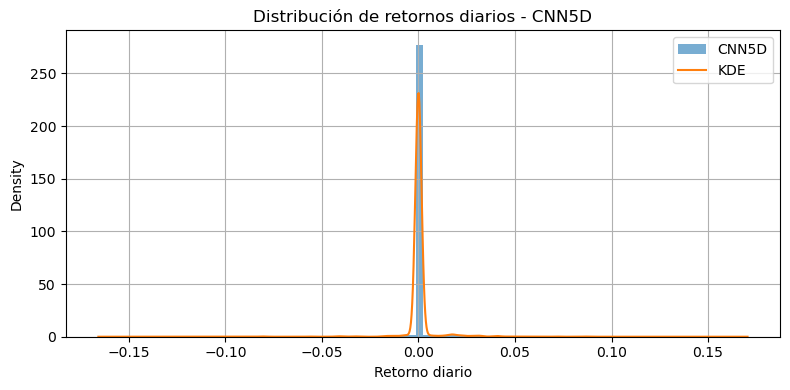

In [31]:
plt.figure(figsize=(8,4))
ret_sys.hist(bins=50, density=True, alpha=0.6, label="CNN5D")
ret_sys.plot(kind="kde", label="KDE")
plt.title("Distribución de retornos diarios - CNN5D")
plt.xlabel("Retorno diario")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


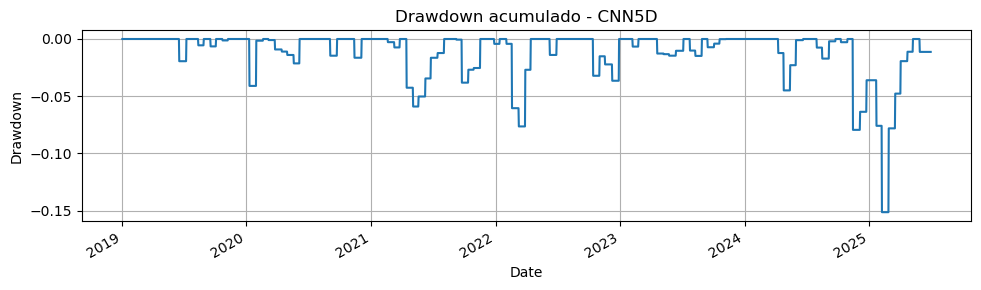

In [33]:
cum_returns = (1 + ret_sys).cumprod()
rolling_max = cum_returns.cummax()
drawdown = cum_returns / rolling_max - 1

plt.figure(figsize=(10,3))
drawdown.plot()
plt.title("Drawdown acumulado - CNN5D")
plt.ylabel("Drawdown")
plt.grid()
plt.tight_layout()
plt.show()


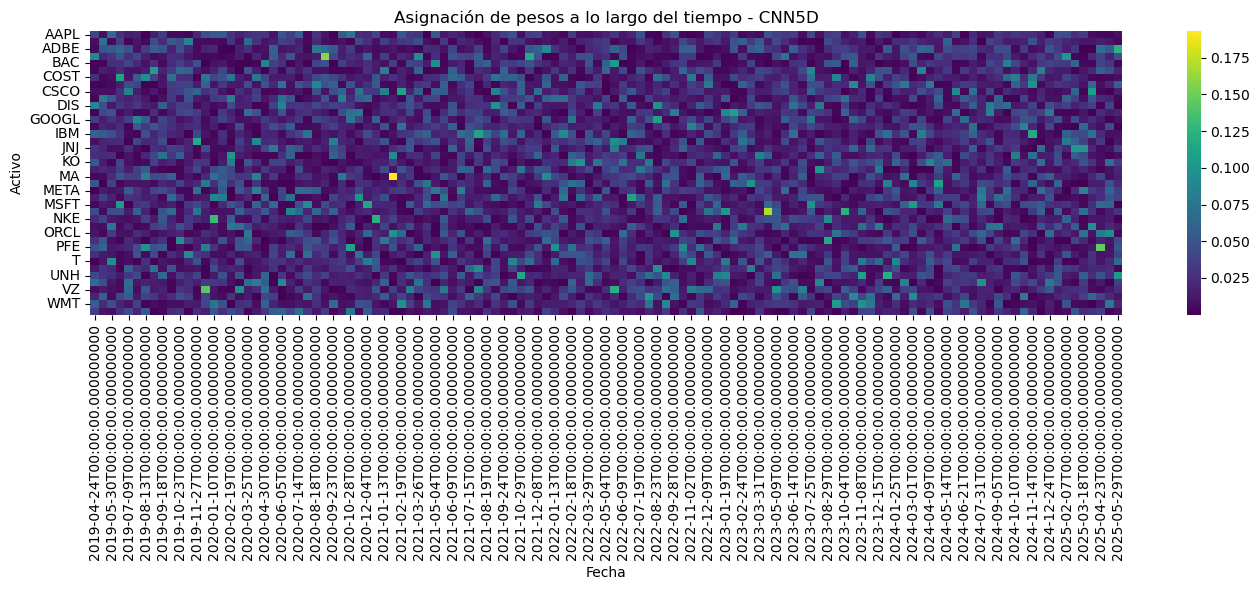

In [35]:
df_prices = pd.read_parquet(cfg.DATA / "raw" / "prices.parquet")
tickers = df_prices.columns[:res_df["w_star"].iloc[0].shape[0]]

df_w = pd.DataFrame(
    [r["w_star"] for r in res_df.dropna().to_dict(orient='records')],
    index=res_df.dropna().index,
    columns=tickers
)

plt.figure(figsize=(14,6))
sns.heatmap(df_w.T, cmap="viridis", cbar=True)
plt.title("Asignación de pesos a lo largo del tiempo - CNN5D")
plt.xlabel("Fecha")
plt.ylabel("Activo")
plt.tight_layout()
plt.show()


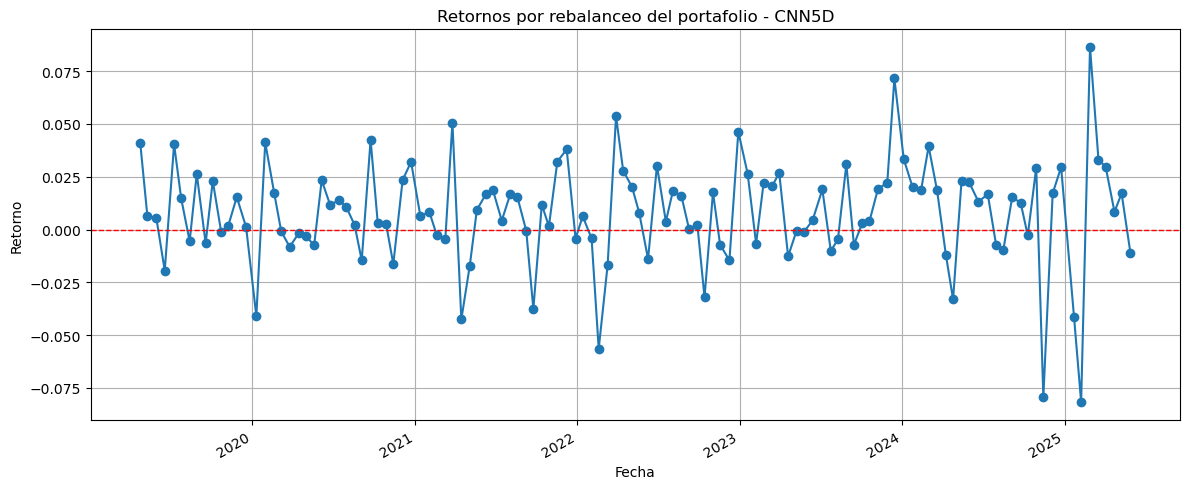

In [37]:
plt.figure(figsize=(12, 5))
res_df["retorno"].plot(marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Retornos por rebalanceo del portafolio - CNN5D")
plt.ylabel("Retorno")
plt.xlabel("Fecha")
plt.grid(True)
plt.tight_layout()
plt.show()
